### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-20/04/20
#### Clasificacion de imagenes motoras en EEG con Transfer Learning
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Data Augmentation

##### VGG16
##### Accuracy = 45.83%
##### Kappa = 0.2778

##### InceptionV3
##### Sujeto 1
##### Accuracy = 45.83%
##### Kappa = 0.2778

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

Using TensorFlow backend.


In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (299, 299) #ancho, alto
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((2816,1000,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      x = abs(coef)
      temporal[j*128:(j+1)*128, :, 0] = x
      temporal[j*128:(j+1)*128, :, 1] = x
      temporal[j*128:(j+1)*128, :, 2] = x
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

66.0605704209217
58.92652956329641
0.002633029815965031
0.0028018946790724928
3.8612014821606695
3.7636597542096775


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 67.0
x_test /= 67.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.98597866
0.87950045
3.9298953e-05
4.1819323e-05
0.05762994
0.056173973


In [0]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [0]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
#base_model.summary()

In [0]:
#Extraccion de caracteristicas con VGG16
x_train = base_model.predict(x_train)
print(x_train.shape)

x_test = base_model.predict(x_test)
print(x_test.shape)

(288, 8, 8, 2048)
(288, 8, 8, 2048)


In [0]:
def transfer_learning():
  model = Sequential()
  model.add(Flatten(input_shape=x_train.shape[1:]))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (288, 8, 8, 2048) (2048 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/100
16/16 - 11s - loss: 1.4547 - accuracy: 0.2951 - val_loss: 1.3999 - val_accuracy: 0.2812
Epoch 2/100
16/16 - 11s - loss: 1.3931 - accuracy: 0.3438 - val_loss: 1.3343 - val_accuracy: 0.3924
Epoch 3/100
16/16 - 11s - loss: 1.3693 - accuracy: 0.2986 - val_loss: 1.3059 - val_accuracy: 0.3681
Epoch 4/100
16/16 - 11s - loss: 1.2924 - accuracy: 0.3924 - val_loss: 1.2881 - val_accuracy: 0.4097
Epoch 5/100
16/16 - 11s - loss: 1.3144 - accuracy: 0.3507 - val_loss: 1.2930 - val_accuracy: 0.3715
Epoch 6/100
16/16 - 11s - loss: 1.3045 - accuracy: 0.3611 - val_loss: 1.2745 - val_accuracy: 0.3819
Epoch 7/100
16/16 - 11s - loss: 1.2403 - accuracy: 0.3854 - val_loss: 1.2653 - val_accuracy: 0.3507
Epoch 8/100
16/16 - 11s - loss: 1.2432 - accuracy: 0.4549 - val_loss: 1.2464 - val_accuracy: 0.3785
Epoch 9/100
16/16 - 11s - loss: 1.2116 - accuracy: 0.4549 - val_loss: 1.2449 - val_accuracy: 0.3924
Epoch 10/100
16/16 - 11s - loss: 1.1950 - accuracy: 0.4549 - val_loss: 1.2329 - val_accuracy: 0.3889

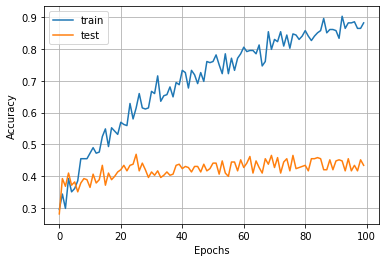

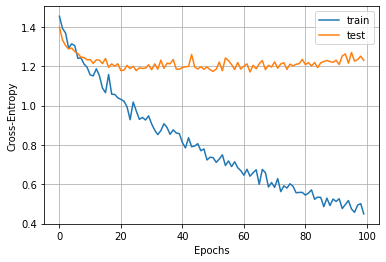


Resultados:
loss: [1.2304651737213135]
accuracy: [0.4340277910232544]
kappa: [0.24537037037037035]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)
    
  model = transfer_learning()

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=100,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)
  
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                8388672   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 8,388,932
Trainable params: 8,388,932
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.4340
std: (+/- 0.0000)
Mean Kappa: 0.2454
std: (+/- 0.0000)
Max Accuracy: 0.4340
Max Kappa: 0.2454
